In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("lab05.ipynb")

# Lab 5:  Rejection Sampling, Gibbs Sampling and GLM

Welcome to the 5th Data 102 lab! 

The goal of this Lab is to get you familiar with rejection sampling, gibbs sampling, as well as give you additional practice utilizing Bayesian analysis methods with PyMC.

## Collaboration Policy
You can submit the lab in pairs (groups of two, no more than two). **If you choose to work in a pair, please make sure to add your group member on Gradescope for both Lab 05 written submission and the Lab 05 code submission.**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually and do not share your code with anyone other than your partner**. If you do discuss the assignments with people other than your partner please **include their names** in the cell below.

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

## Submission
Since this lab involves sampling, **tests may take awhile to run. Please submit as early as possible, as last minute submissions may overwhelm DataHub, preventing yourself and others from submitting on-time.**

For full credit, this assignment should be completed and submitted before **Wednesday, Feb 26th, 2025 at 5:00 PM PST.**

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal, norm, uniform
from ipywidgets import interact, interactive

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

import pymc as pm

import hashlib

sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

import statsmodels.api as sm

import bambi as bmb

import arviz as az


## Setup

In this lab, you are given a two dimensional unnormalized density function $q(x,y)$ represented by `target_density` below. The goal of Question 1 of this lab is to build up a sampler that can output samples from the distribution proportional to $q(x,y)$. 

In **Question 1** we will compute samples via *Rejection Sampling*. In part **1a** we will build a sampler for a 1-dimensional projection of the density. In part **1b** we will extend the approach to two dimensions.

*Throughout Question 1, we will assume that our computers have access only to normal and uniform random variables.*

In [5]:
# This is the target unnormalized density from which we would like to sample
# Run this to define the function
# No TODOs here
@np.vectorize # <- decorator, makes function run faster
def target_density(x, y):
    mean1 = [1, 1.7]
    mean2 = [2, 1.3]
    mean3 = [1.5, 1.5]
    mean4 = [2, 2.1]
    mean5 = [1, 1.2]
    cov1=0.2*np.array([[0.2, -0.05], [-0.05, 0.1]])
    cov2 = 0.3*np.array([[0.1, 0.07], [0.07, 0.2]])
    cov3= np.array([[0.1, 0], [0, 0.1]])
    cov4 = 0.1*np.array([[0.3, 0.04], [0.04, 0.2]])
    cov5 = 0.1*np.array([[0.4, -0.04], [-0.04, 0.2]])
    return(multivariate_normal.pdf([x, y], mean=mean1, cov=cov1) + 
           multivariate_normal.pdf([x, y], mean=mean2, cov=cov2) +
           2*multivariate_normal.pdf([x, y], mean=mean3, cov=cov3) +
           0.5*multivariate_normal.pdf([x, y], mean=mean4, cov=cov4)+
           0.5*multivariate_normal.pdf([x, y], mean=mean5, cov=cov5))

#### Let's visualize this density. 

Run the cell below to see a 3D plot of the function along with a contour plot.

In [6]:
# No TODOs here, just run the cell to make plots
# Create a meshgrid of coordinates
coords = np.arange(0.5, 2.5, 0.02)
X, Y = np.meshgrid(coords, coords)

# Compute the value of the target density at all pairs of (x,y) values
Z = target_density(X,Y)

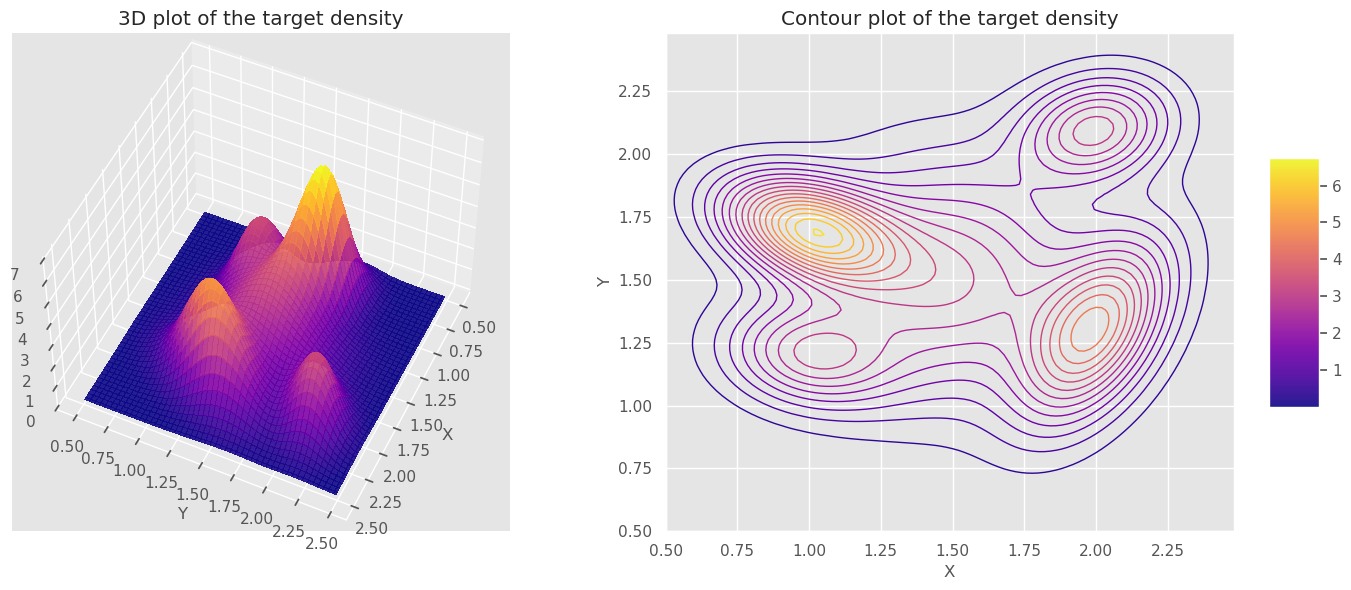

In [7]:
# Display the 3D plot of the target density
fig = plt.figure(figsize=(15,6))

ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122)

surf = ax0.plot_surface(X,Y,Z, cmap=cm.plasma, linewidth=0, antialiased=False,alpha = 0.9,)

# Customize the z axis.
ax0.set_zlim(0, 7)
ax0.set_xlabel("X")
ax0.set_ylabel("Y")
ax0.set_zlabel("Z")
ax0.set_title("3D plot of the target density")

# Rotate the axes: you can change these numbers in order to see the distribution from other angles
ax0.view_init(50, 25)

# Plot the contour plot of the density
cont = ax1.contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1)
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_title("Contour plot of the target density")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, ax=ax1)
plt.tight_layout()
plt.show()

Take a moment to examine the plots. Make sure you can see correspondances between each peak in the 3D plot on the left; and the "high-altitude" regions in the countour plot on the right.

Next we will plot 1-dimensional projections of the target densities onto the $X$ and $Y$ axis. These correspond to conditional target distributions of the form $q(x, y=y')$ and $q(x=x', y)$.

In [8]:
# Do not modify
# Run the cell below to define the plotting functions

COORDINATES = np.arange(0, 3, 0.02)
def plot_x_cond(y_val):
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(12)
    axs[0].contour(X,Y,Z, levels = 20, cmap=cm.plasma, alpha = 0.8, linewidths=0.8)
    axs[0].axhline(y_val,  ls="--", color = 'olive', lw = 2)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title("Contour plot of the target density")
    
    axs[1].plot(COORDINATES, target_density(COORDINATES, y_val), color = 'olive')
    axs[1].set_ylim(0,10)
    axs[1].set_xlim(0,3)
    axs[1].set_xlabel("X")
    axs[1].set_title("Conditional target density: q(x | y={:.1f})".format(y_val))
    plt.show()
    
def plot_y_cond(x_val):
    fig, axs = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(12)
    axs[0].contour(X,Y,Z, levels = 20, cmap=cm.plasma, alpha = 0.8, linewidths=0.8)
    axs[0].axvline(x_val,  ls="--", color = 'olive', lw = 2)
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].set_title("Contour plot of the target density")
    
    axs[1].plot(COORDINATES, target_density(x_val, COORDINATES), color = 'olive')
    axs[1].set_ylim(0,10)
    axs[1].set_xlim(0,3)
    axs[1].set_xlabel("Y")
    axs[1].set_title("Conditional target density: q(y | x={:.1f})".format(x_val))
    plt.show()

In [9]:
# Display interactive plot
interactive_plot = interactive(plot_x_cond, y_val=(0, 3, 0.1), add_proposal=False)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='y_val', max=3.0), Output()), _dom_classes=('widget-i…

Set different values of `y_val`, observe the changes in the conditional target density.

In [10]:
# Display interactive plot
interactive_plot = interactive(plot_y_cond, x_val=(0, 3, 0.1), add_proposal=False)
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='x_val', max=3.0), Output()), _dom_classes=('widget-i…

Set different values of `x_val`, observe the changes in the conditional target density.

<!-- BEGIN QUESTION -->

### A Quick Understanding Check:

We said that $q$ is an unnormalized density function. What does this mean? How could we test whether or not the function is normalized?

If q is an unnormalized density function then it represents a probability density up to a constant factor, but it does not necessarily integrate to 1. More formally, the function provides the correct relative probabilities, but its total probability mass may be greater or less than 1. We can test whether a function is normalized by taking a double integral over the entire domain of $x$ and $y$. If the integral is approximately 1 then q is normalized, if the integral is greater or less than 1 then it's unnormalized, we can normalize it by dividing $q$, by the result of the integral.  

<!-- END QUESTION -->

## Part I: Rejection Sampling and Gibbs Sampling

### Question 1: Rejection Sampling

In this question, we will build a rejection sampler. First, let's review the basics. 

Assume we want to sample from an unnormalized target density $q(x)$, using a proposal distribution $F$, with density $f(x)$. The proposal distribution is chosen such that we have access to samples from it. 

#### Rejection sampling proceeds as follows:

- Find constant $c$, such that $cq(x)\leq f(x)$ on the support
- At each iteration:
    - Sample $x_i \sim F$
    - Compute the ratio $r = \frac{c(q(x_i))}{f(x_i)} \leq 1$
    - Sample $\gamma_i \sim {\rm Uniform}(0,1)$:
        - `accept` the sample if $\gamma_i \leq r$: Add $x_i$ to the list of samples.
        - `reject` the sample otherwise: do nothing
        
### 1(a) Sample from the one-dimensional density $q(x, y=1.2)$
Throughout part 1.a, we will restrict our attention to the range $[0,3]$ for simplicity. That way we can use Uniform(0,3) as our proposal distribution. Meaning that $f(x) = \frac{1}{3} \ \forall x\in[0,3]$.

In [11]:
# Create the target 1D density q(x, y = 1.2)
def target_1D_density(x):
    return(target_density(x, 1.2))

Finish implementing the steps of the rejection sampling algorithm by filling in the following code.

*Hint: both `scipy` and `numpy` provide methods for drawing from a uniform distribution.*

In [12]:
def sample_1D_proposed_distribution(N):
    """ 
    Produces N samples from the Uniform(0,3) proposal distribution
    
    Inputs:
        N : int, desired number of samples
        
    Outputs:
        proposed_samples : an 1d-array of size N which contains N independent samples from the proposal
    """
    return np.random.uniform(0,3,size=N)

@np.vectorize
def compute_ratio_1D(proposed_sample, c):
    """
    Computes the ratio between the scaled target density and proposal density evaluated at the 
    proposed sample point
    
    Inputs:
        proposed_sample : float, proposed sample
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        ratio : float
    """
    proposal_density = 1/3
    target_density= target_1D_density(proposed_sample)
    ratio = (c* target_density) / proposal_density
    return np.clip(ratio, 0, 1)

@np.vectorize
def accept_proposal(ratio):
    """ 
    Accepts or rejects a proposal with probability equal to ratio
    
    Inputs: 
        ratio: float, probability of acceptance
    
    Outputs:
        accept: True/False, if True, accept the proposal
    """
    return np.random.uniform(0, 1) <= ratio

You can use the following cell to test your functions to convince yourself that they work. 

In [13]:
# WRITE YOUR TEST CASES HERE

Now we have all the ingredients for making a sampler:

In [14]:
def get_1D_samples(N, c): 
    """ 
    Produces samples from target_1D_density
    
    Inputs:
        N : int, number of proposed_samples
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        rejection_samples : an 1d-array which contains independent samples from the target
    """
    proposed_samples = sample_1D_proposed_distribution(N)
    ratios = compute_ratio_1D(proposed_samples, c)
    accepted = accept_proposal(ratios)
    return proposed_samples[accepted]

In [15]:
grader.check("q1a_ii")

q1a_ii results: All test cases passed!

From the interactive plots we made earlier, we can see that $q(x, y=1.2)$ is allways smaller than 5. Hence to make it smaller than $f(x) = 1/3$ we need to scale the target density by a factor $c \leq \frac{1}{3}\cdot\frac{1}{5} = 1/15$. 

#### Let's use $c=1/15$, compute target samples and plot their histogram

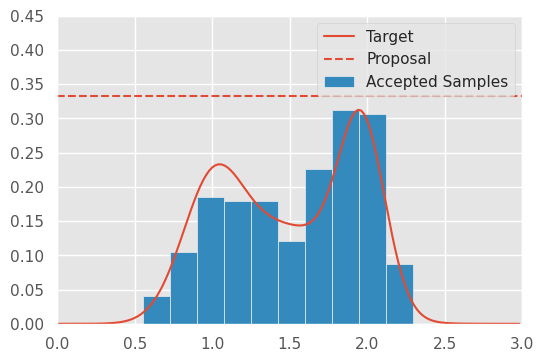

In [16]:
# No TODOs here
# Just run it once you passed the tests above

fig = plt.figure(figsize = (6, 4))
c = 1/15
target_samples = get_1D_samples(1000, c)
density_values =  target_1D_density(COORDINATES)*c
plt.plot(COORDINATES, density_values, label='Target')
plt.axhline(1/3, ls = '--', label = 'Proposal')
n, bins, rects = plt.hist(target_samples, density = True, label="Accepted Samples")
max_height = np.max([r.get_height() for r in rects])
for r in rects:
    r.set_height(r.get_height()*np.max(density_values)/max_height)
plt.legend()
plt.xlim(0,3)
plt.ylim(0,0.45)
plt.show()

#### Computing the acceptance ratio for varying scaling constants c

In [17]:
# No TODOs here
# Just run it and comment in the section below

N = 1000
c_values = [0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
for c in c_values:
    # compute target samples
    target_samples = get_1D_samples(N, c)
    acceptance_percentage = 100*len(target_samples)/N
    print("For c = {:.2f}, the acceptance percentage is {:.1f}%".format(c, acceptance_percentage))

For c = 0.06, the acceptance percentage is 28.6%
For c = 0.05, the acceptance percentage is 22.7%
For c = 0.04, the acceptance percentage is 18.3%
For c = 0.03, the acceptance percentage is 14.6%
For c = 0.02, the acceptance percentage is 8.4%
For c = 0.01, the acceptance percentage is 4.0%


<!-- BEGIN QUESTION -->

#### In the cell below explain why the accepted percentage decreases as $c$ decreases:

Recall, the formula for the acceptance ratio is given by:

$$r = \frac{c \cdot q(x)}{f(x)}$$  Where $r \leq 1$, $c$ is the scaling factor, $q(x)$ is the target density, and $f(x)$ is the proposal distribution.

When $c$ is too large, there may be regions where $c \cdot q(x) > f(x)$, which violates the rejection sampling requirement. Moreover, recall the sampling requirement exists when we are choosing an appropriate scaling factor, $c$, we need to ensure that the scaled target density $c \cdot q(x)$ never exceeds the proposal density, $f(x)$. More formally:  $$c \cdot q(x) \leq f(x)$$

When $c$ is too small, all values of $q(x)$ are scaled down, leading to lower acceptance rates

<!-- END QUESTION -->

### 1(b) Sample from the two-dimensional density $q(x, y)$

In two dimensions Rejection Sampling is nearly identical to the 1-dimension case:

- Find constant $c$, such that $cq(x, y)\leq f(x, y)$ on the support
- At each iteration:
    - Sample $(x_i, y_i) \sim F$
    - Compute the ratio $r = \frac{c(q(x_i, y_i))}{f(x_i, y_i)} \leq 1$
    - Sample $\gamma_i \sim {\rm Uniform}(0,1)$:
        - `accept` the sample if $\gamma_i \leq r$: add $(x_i, y_i)$ to the list of samples.
        - `reject` the sample otherwise: do nothing

Throughout part 1.b we will consider $(x, y)\sim {\rm Uniform}(0,3)\times {\rm Uniform}(0,3)$ as our proposal distribution. Meaning that $f(x, y) = \frac{1}{9}\ \forall x, y\in[0,3]$

Fill in the 2-d ratio calculation:

In [18]:
@np.vectorize
def compute_ratio_2D(proposed_sample_x, proposed_sample_y, c):
    """
    Computes the ratio between the scaled target density and proposal density evaluated at the 
    proposed sample point
    
    Inputs:
        proposed_sample_x : float, x components of the proposed sample point
        proposed_sample_y : float, y components of the proposed sample point
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        ratio : float
    """
    target_density_value = target_density(proposed_sample_x, proposed_sample_y)
    ratio = 9 * c * target_density_value
    assert(ratio <= 1)
    return(ratio)

Use the following cell to convince yourself that your code is correct:

In [19]:
# WRITE YOUR TEST CASES HERE

Now we have all the ingredients for making the 2-d sampler.

In [20]:
# No TODOs here, just run the 2D version of the functions we built in 1.a
def get_2D_samples(N, c): 
    """ 
    Produces samples from target_density
    
    Inputs:
        N : int, number of proposed_samples
        c : float, constant scaling factor that ensures that the proposal density is above the target density
        
    Outputs:
        rejection_samples : ndarray of which contains independent samples from the target
    """
    proposed_samples_x = sample_1D_proposed_distribution(N)
    proposed_samples_y = sample_1D_proposed_distribution(N)
    ratios = compute_ratio_2D(proposed_samples_x, proposed_samples_y, c)
    accept_array = accept_proposal(ratios)
    proposed_samples = np.concatenate((proposed_samples_x.reshape(N,1), proposed_samples_y.reshape(N,1)), axis = 1)
    rejection_samples = proposed_samples[accept_array]
    return(rejection_samples)

In [21]:
grader.check("q1b_i")

q1b_i results: All test cases passed!

From the contour plot we made previously, we can see that $q(x, y=1.2)$ is allways smaller than 7.4. Hence to make it smaller than $f(x) = 1/9$ we need to scale the target density by a factor $c \leq \frac{1}{7.4}\cdot\frac{1}{8} = 0.015$. 

#### Let's use $c=0.015$, compute target samples and plot them on top the contour lines

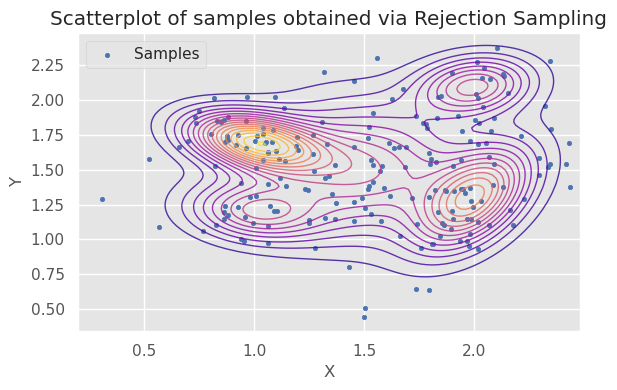

In [22]:
fig = plt.figure(figsize=(6,4))

# Plot the contour plot of the density
cont = plt.contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1, alpha = 0.8)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatterplot of samples obtained via Rejection Sampling")

# Add sample points obtained via rejection sampling
c = 1/72
target_samples = get_2D_samples(3000, c)
plt.scatter(target_samples[:,0], target_samples[:,1], c='b', alpha = 1, s = 10, label = 'Samples')

plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# No need to modify this
# just run it and comment in the section below

N = 3000
c_values = [0.015, 0.01, 0.005, 0.001]
for c in c_values:
    # compute target samples
    target_samples = get_2D_samples(N, c)
    acceptance_percentage = 100*len(target_samples)/N
    print("For c = {:.3f}, the acceptance percentage is {:.1f}%".format(c, acceptance_percentage))

For c = 0.015, the acceptance percentage is 7.4%
For c = 0.010, the acceptance percentage is 4.4%
For c = 0.005, the acceptance percentage is 2.6%
For c = 0.001, the acceptance percentage is 0.5%


<!-- BEGIN QUESTION -->

#### In the cell below explain why the accepted percentage when sampling from 2D distribution is so much smaller than sampling from the 1D version in 1(a).

In 2D, the proposal distribution is Uniform (0,3) x Uniform(0,3), which means that we now need to sample two independent variables. This results in a larger proposal space where more proposals fall in regions with lower probability density. Thus, the volume of space where the target density is significant is relatively small compared to the total proposal space. Recall, the sampling requirement defined in the previous response, in order for the requirement to hold the scaling factor, $c$, must be smaller in 2D than in 1D, leading to lower acceptance rates (higher rejection rates). More formally, the proposal density in 1D, $f(x)$ is,  $\frac{1}{3}$ in 2D its,  $\frac{1}{9}$. Therefore, the maximum value of the target density is higher in 2D, leading to an even smaller factor, $c$, which further reduces the acceptance rate.

<!-- END QUESTION -->

### Question 2: Gibbs Sampling

In this question, we will build a Gibbs sampler and apply it to the same density. First, let's go over the basics of Gibbs Sampling.

Assume we want to sample from an unnormalized target density $q(x, y)$. 

#### Gibbs Sampling proceeds as follows:

- Start at an initial point $(x_0, y_0)$
- For `i` in `number of iterations`:
    - Condition on $y=y_{i-1}$: Sample $x_i \sim q(x \mid y=y_{i-1})$ 
        - Add $(x_i, y_{i-1})$ to the list of samples
    - Condition on $x=x_{i}$: : Sample $y_i \sim q(y \mid x=x_{i})$ 
        - Add $(x_i, y_{i})$ to the list of samples
    
In many problems we can sample the univariate distributions directly. In this case we don't know how to sample them directly, but we can use the 1-D rejection sampler that we computed in Question 1.

In the cell below, we wrote helper functions that sample from the conditionals above. They are essentially the same function you wrote in Question 1, just slightly modified such that we perform rejection sampling until we get one valid sample.

In [24]:
# No TODOs here:
# Just look at these helper functions and make sure you understand the syntax

def sample_x_cond(fixed_y_val):
    """ 
    Produces one sample from x_i ~ q(x | y=fixed_y_val)
    
    Inputs:
        fixed_y_val : float, current value of y, on which we condition
    
    Outputs:
        x_sample: float, one sample from x_i ~ q(x, y=fixed_y_val)
        num_samples : int, number of tries until we accepted a sample
        
    """
    def conditional_density(x):
        return(target_density(x, fixed_y_val))
    x_sample = None
    num_samples = 0
    c = 0.33/(0.2+max(conditional_density(np.arange(0.5, 2.5, 0.05)))) # <- we are cheating a bit here by 
                                                                       # looking for a tight c value
    while x_sample is None:
        proposed_sample = sample_1D_proposed_distribution(1)
        num_samples += 1
        ratio = conditional_density(proposed_sample)*3*c
        assert(ratio <= 1)
        accept = accept_proposal(ratio)
        if accept:
            x_sample = proposed_sample[0]
    return(x_sample, num_samples)


def sample_y_cond(fixed_x_val):
    """ 
    Produces one sample from y_i ~ q(y | x=fixed_x_val)
    
    Inputs:
        fixed_x_val : float, current value of y, on which we condition
    
    Outputs:
        y_sample: float, one sample from y_i ~ q(y | x=fixed_x_val)
        num_samples : int, number of tries until we accepted a sample
        
    """
    def conditional_density(y):
        return(target_density(fixed_x_val, y))
    y_sample = None
    num_samples = 0
    c = 0.33/(0.2+max(conditional_density(np.arange(0.5, 2.5, 0.05))))
    while y_sample is None:
        proposed_sample = sample_1D_proposed_distribution(1)
        num_samples += 1
        ratio = conditional_density(proposed_sample)*3*c
        assert(ratio <= 1)
        accept = accept_proposal(ratio)
        if accept:
            y_sample = proposed_sample[0]
    return(y_sample, num_samples)

### 2(a) Build a Gibbs sampler using the helper functions above
**Note**: Don't forget that at each iteration the Gibbs sampler adds two samples to the list of samples: $(x_i, y_{i-1})$ and $(x_i, y_{i})$

**Hint 1**: If you cannot pass the test, try making a simple test case with `N=2` and adding some print statements to your code.

**Hint 2**: In our implementation of Gibbs sampling, `num_samples` is not trivially equal to `N`, since sampling $x_i \sim q(x \mid y=y_{i-1})$ and $y_i \sim q(y \mid x=x_{i})$ rely on rejection sampling.

In [25]:
def get_2D_Gibbs_samples(N, x_0, y_0):
    """
    Produces N samples from the target density using Gibbs Sampling
    
    Inputs: 
        N : desired number of samples
        x_0, y_0 : floats, the coordinates of the starting point
        
    Outputs:
        gibbs_samples : array of dimension (N, 2) where each row is a sample from the target distribution
                        of the form (x_i, y_i)
        num_samples : total number of samples required
    """
    gibbs_samples = [] # Each entry corresponds to a (x_i, y_i)
    num_samples = 0 # Add the number of samples to this variable, note this is not equal to N since rejection sampling
                    # does not accept every sample
    x_curr = x_0 # Current value of x, initialized to x_0
    y_curr = y_0 # Current value of y, initialized to y_0
    
    for i in range(N//2): # The range is N//2 since we are generating two gibbs samples in one iteration
        x_sample, x_reject_attempts = sample_x_cond(y_curr)
        num_samples += x_reject_attempts
        gibbs_samples.append((x_sample, y_curr))

        y_sample, y_reject_attempts = sample_y_cond(x_sample)
        num_samples += y_reject_attempts
        gibbs_samples.append((x_sample, y_sample))

        x_curr, y_curr = x_sample, y_sample
        
    return np.array(gibbs_samples), num_samples

In [26]:
grader.check("q2a")

q2a results: All test cases passed!

### 2(b)  Path traced by the Gibbs sampler
Run the code below to overlay the path traced by the Gibbs Sampler:

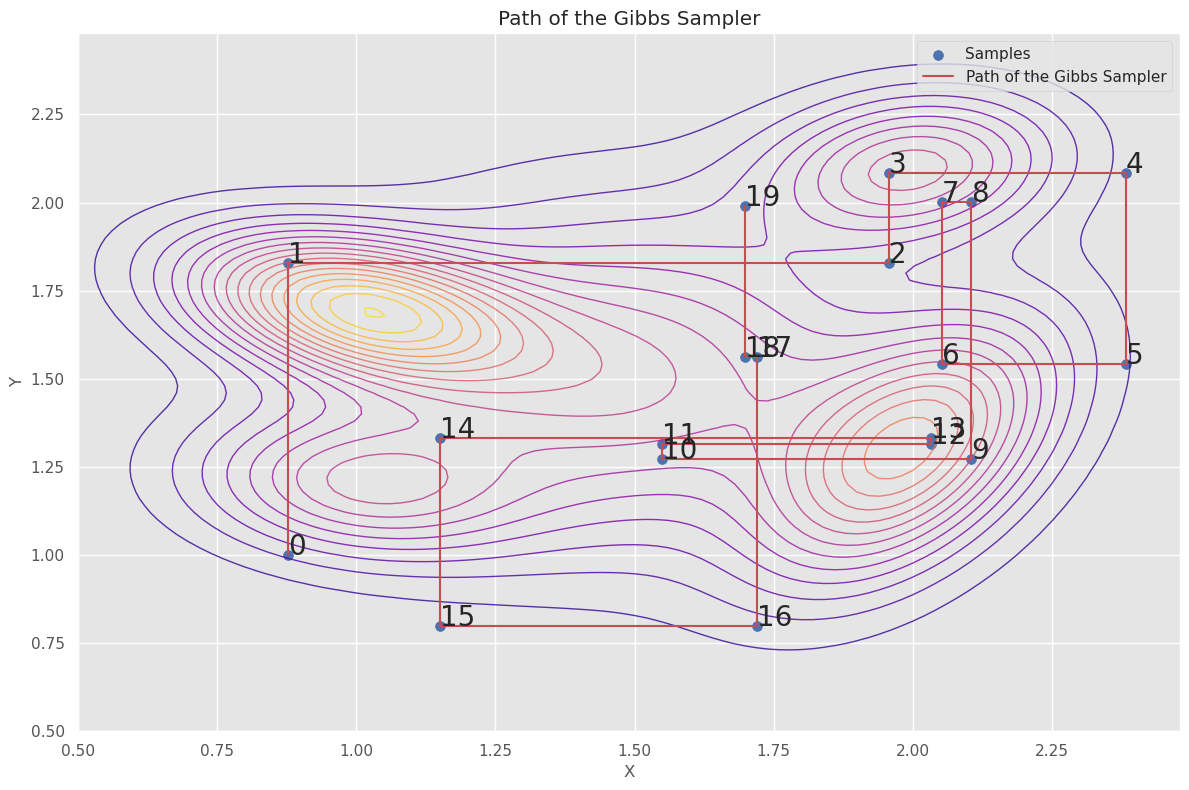

In [27]:
# Do not modify
# Just run this once you've passed the validation tests above
N = 20
target_samples, total_samples = get_2D_Gibbs_samples(N, 1, 1)
target_samples = np.array(target_samples)

fig = plt.figure(figsize=(12,8))

# Plot the contour plot of the density
cont = plt.contour(X,Y,Z, levels = 20, cmap=cm.plasma, linewidths=1, alpha = 0.8)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Path of the Gibbs Sampler")

# Add sample points obtained via Gibbs sampling
plt.scatter(target_samples[:,0], target_samples[:,1], c='b', alpha = 1, s=50, label = 'Samples')
for i in range(N):
    plt.annotate(i, (target_samples[i,0], target_samples[i,1]), fontsize = 20)
plt.plot(target_samples[:,0], target_samples[:,1], c='r', alpha = 1, label = 'Path of the Gibbs Sampler')

plt.legend()
plt.tight_layout()
plt.show()

<!-- BEGIN QUESTION -->

#### Inspect the scatter plot above. Trace the Gibbs sampler path from the initial point (labeled 0) to the final point. What do you notice about the orientation of the paths between each point? Why are they oriented in this way?

The paths traced by the samples follow a distinct axis-aligned pattern, moving either horizontally or vertically in each step. Recall, in Gibbs sampling we alternately sample one variable while keeping the other fixed. For example, in one step, we sample $x$ given the previous $y$, so only the $x$-coordinate while $y$ stays constant. In the step, we sample $y$ given the updated $x$, so only the $y$-coordinate changes while $x$ stays constant. Thus, each step only updates one variable at a time, leading to movements along coordinate axes rather than diagonal or arbitrary directions.

<!-- END QUESTION -->

### 2(c) 'Efficiency' of Gibbs Sampling
Let's compute 1000 Gibbs samples and compute how many times the rejection sampling subroutine accepted the proposed sample (running this might take a little while):

In [28]:
# No need to modify this
# just run it and comment in the section below
N = 1000
target_samples, total_samples = get_2D_Gibbs_samples(N, 1, 1)
acceptance_rate = N/total_samples*100
print("The acceptance rate for Gibbs Sampling is {:.1f}%".format(acceptance_rate))

The acceptance rate for Gibbs Sampling is 25.0%


<!-- BEGIN QUESTION -->

#### How does Gibbs Sampling compare to vanilla Rejection Sampling from Question 1? Is this approach more efficient or less efficient? What is the source of this increase/decrease in efficiency?

The acceptance rate for Gibbs Sampling in the expirement is 24.9%, which is significantly higher than what was observed for rejection sampling in Question 1, especially in the 2D case where the acceptance rate was very low. Yes, this approach is more efficient, a higher acceptance rate means fewer proposed samples are rejected, leading to a faster convergence and a more efficient sampling process. For example, when using rejection sampling directly in two dimensions the probability of a random proposal being accepted is low because we must satisfy a strict acceptance condition for both variables simultaneously. In contrast, instead of sampling both variables at once Gibbs sampling samples one variable at a time, conditioning on the other. This leads to a higher probability of acceptance in each step. A source of the increased efficiency is Gibbs sampling avoids full rejection of entire proposals by updating one variable at a time. In addition, Gibbs sampling becomes more efficient in comparison to rejection sampling as dimensionality increases.

<!-- END QUESTION -->

## Part II: GLMs

Now, we will pivot to discussing frequentist and Bayesian approaches to generalized linear models. This question will be easier after Tuesday's lecture!

## Question 3: Atlantic Hurricane Season

With 30 named storms, the 2020 Atlantic hurricane season was the most active on record. Climate scientists argue that the culprit is human induced global warming. There is a an evergrowing body of research linking increased average temperatures and rising sea levels to more frequent, more intense and more destructive storms. 

In this lab we will investigate the number of named storms recorded since 1880, and we will argue that there is a statistically significant relationship between rising Sea Surface Temperature (SST) and the frequency of named storms.

For this lab we extracted the number of tropical storms from the [HURDAT Database](https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2019-052520.txt). We also extracted data on Sea Surface Temperatures from the [National Center for Atmosferic Research](https://climatedataguide.ucar.edu/climate-data/global-surface-temperature-data-gistemp-nasa-goddard-institute-space-studies-giss). 

### Load the data

In [29]:
# No need to modify: Just run the code to load the data
data_source = "hurricane_data.csv"
df = pd.read_csv(data_source)
df = df[["Year", "Num_Storms", "Temp_Anomaly"]]
df.tail()

,Year,Num_Storms,Temp_Anomaly
135,2015,11,1.28
136,2016,15,1.12
137,2017,17,1.10
138,2018,15,1.07
139,2019,18,1.24


### Model Specifications

The `Num_Storms` column contains the number of named storms recorded each year between 1880 and 2019. The `Temp_Anomaly` column contains the deviation in yearly SST from the mean of 1951-1980.

In this question, to show that there is a statistically significant relationship between rising Sea Surface Temperature (SST) and the frequency of named storms, we will model the number of named storms in Year $i$ using **Poisson Regression**:

$$\lambda_i = e^{q_0 + q_1 X_i}$$ 

$$C_i \sim \text{Poisson}(\lambda_i),$$

where $X_i$ is the SST deviation in Year $i$, and $C_i$ is the number of named storms in year $i$.

This isn't something that we can easily solve from scratch, so we have to use software packages. In this question, we'll explore the two approaches to GLMs that we covered in class: 

1. **Q3(b): Frequentist Regression** using [`statsmodels.api`](https://www.statsmodels.org/stable/glm.html) 
2. **Q3(c) Bayesian Regression** via sampling using [`PyMC`](https://www.pymc.io/welcome.html) and [`Bambi`](https://bambinos.github.io/bambi/)

<!-- BEGIN QUESTION -->

## 3(a) Understanding Check

The model we described above is a GLM. What is "Linear" about this GLM model? What's the inverse link function? 


The model has a link function $g(\lambda_i)$, which transforms the mean response to a linear function of the predictors. Also, $\beta_0 + \beta_1 X_i$ is a linear combination of the predictors. Although the response variable $C_i$ follows a Poisson distribution, the model is linear in the sense that the transformed mean response $g(\lambda)$ is a linear function of the predictor, $X_i$.  The inverse link function maps from the linear predictor back to the mean of the response:
$$\lambda = e^{q_0 + q_1 X_i}$$ 

This means that instead of predicting storm counts directly, we predict their logarithm, ensuring that our predicted values are always positive. 

<!-- END QUESTION -->

## 3(b) Frequentist Regression

Let's start by considering the problem from a frequentist lens. To do this, we'll use the `statsmodels.api`, which allows us to create a model in just a few lines of code.

After fitting our model, we can call the `.summary()` method, and get a breakdown of our model and some details on how well it fit our data.

In [30]:
# Fit Poisson GLM model where Temp_Anomaly is a covariate (exogenous variable): No need to modify
freq_model = sm.GLM(df["Num_Storms"], exog = sm.add_constant(df["Temp_Anomaly"]), 
                  family=sm.families.Poisson())
freq_res = freq_model.fit()
print(freq_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Num_Storms   No. Observations:                  140
Model:                            GLM   Df Residuals:                      138
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -376.25
Date:                Sun, 04 May 2025   Deviance:                       183.00
Time:                        05:39:49   Pearson chi2:                     186.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3642
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2414      0.029     78.130   

<!-- BEGIN QUESTION -->

### 3(b)(i) Understanding the table

What variable does `Temp_Anomaly`'s `coef` in the table correspond to in our model? 

The coefficient or Temp_Anomaly is estimated to be 0.4866 and corresponds to $\beta_1$ in our Poisson regression model. More formally, a 1-unit increase in Temp_Anomaly is associated with an increase of $e^{0.4866} \approx 1.63$ times the expected number of storms 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 3(b)(ii) Inspecting the results of fitting `freq_model`. 

Does the model suggest that increased SST relate to more storms? Is the influnce of SST on number of storms statistically significant?

es, the model suggests that increased Sea Surface Temperature (SST) is associated with a higher number of storms. The coefficient for Temp_Anomaly is positive, indicating that as SST increases, the expected number of storms also increases. Moreover, based on the Poisson regression model, which uses a log-link function, the coefficient represents the logarithm of the expected count of storms. Therefore, to interpret the effect on the response variable, we exponentiate the coefficient using base $e$. Since the coefficient for Temp_Anomaly is 0.4866, a one-unit increase in SST anomaly leads to a $e^{0.4866} \approx 1.63$-fold increase in the expected number of storms. Regarding statistical significance, we see that the p-value for Temp_Anomaly is 0.000, which is highly significant (p < 0.001). Additionally, the 95% confidence interval for $\beta_1$ is (0.370, 0.603), which does not include zero, meaning we can confidently conclude that this effect is unlikely to be due to random chance.

<!-- END QUESTION -->

## 3(c) Bayesian Regression via PyMC

Now that we've done Poisson regression the frequentist way with the `statsmodels` package, let's try implementing it the Bayesian way! In this lab we'll explore two ways of doing this:
1. Building the model from scratch in `PyMC`
2. Using `Bambi`, a wrapper on `PyMC` that simplifies model construction

To start, let's build our model from scratch in `PyMC`. Unlike the `statsmodels` package, `PyMC` requires us to specify our model piece by piece. That means that, as with any Bayesian parameter estimation task, we have to distill our problem setup into a likelihood and prior before we can proceed.

### 3(c)(i) Unpacking $C_i \sim \text{Poisson}(\lambda_i)$

Recall the problem setup:

Our model involves the relationship between rising Sea Surface Temperature (SST) and the frequency of named storms, where:

$$\lambda_i = e^{q_0 + q_1 X_i}$$ 

$$C_i \sim \text{Poisson}(\lambda_i),$$

where $X_i$ is the SST deviation in Year $i$, and $C_i$ is the number of named storms in year $i$.

**In the cell below, Choose the option that best fills in the blank in the following statement:**

$C_i \sim \text{Poisson}(\lambda_i)$ represents our _____:

**A.** Prior

**B.** Likelihood

**C.** Posterior

Your answer should be a string, either `"A"`, `"B"`, or `"C"`.

In [31]:
q3c_i = "B"

In [32]:
grader.check("q3c_i")

q3c_i results: All test cases passed!

<!-- BEGIN QUESTION -->

### 3(c)(ii) Picking our prior(s)

Now, let's examine the parameter $\lambda_i = e^{q_0 + q_1 X_i}$. As discussed in lecture, $\lambda_i$ is comprised of a linear function of our observations ($q^TX$) and an inverse-link function ($e$). Given the setup of our problem, answer the following questions using 1 sentence each:
1. How many prior distributions do we need to define?
2. What parameters will we define these prior distributions for?
3. Since we don't have any prior information about these random variables, what distribution (i.e Normal, Beta, etc.) should we pick for their priors?

1. We need to define two prior distributions one for $\beta_0$ (the intercept) and one for $\beta_1$ (the coefficient of $X$, the SST anomaly.
2. We will define priors for $\beta_0$ and $\beta_1$, as they determine the expected number of storms via the log-linked function.
3. A standard choice is to use a Normal distribution with a mean 0 and a large variance to express weak prior information and allow the data to drive inference.  

<!-- END QUESTION -->

### 3(c)(iii) Defining our PyMC Model
Given your answers to `q2c_i` and `q2c_ii`, you're now ready to make your PyMC model! Fill out the code cell below to build your model and sample from the posterior.

**Note:** To pass the test, 
1. Do not remove the variables currently present in the model and/or add your own additional variables. Just fill in any ellipsis; the variables defined here are more than enough for you to solve the question!
2. Make sure the name parameter you pass to each `Distribution` object matches the variable name it's assigned to. Your answers should follow the following format: 

```
with pm.Model() as model:

    q0 = pm.Some_Distribution('q0', ...)
    q1 = pm.Some_Distribution('q1', ...)`
    ...
```

**Hint 1**: Remember that random variables can be added, subtracted, multiplied, etc. just like normal numbers!

**Hint 2**: Not all variables defined in a model context necessarily have to be defined using `pm.Some_Distribution(...)`. In particular, we do not need `pm.Deterministic` when defining `lam`, since we're not interested in its posterior samples. 

In [33]:
with pm.Model() as model:
    q0 = pm.Flat("q0")  
    q1 = pm.Flat("q1")

    lam = pm.math.exp(q0 + q1 *df["Temp_Anomaly"]) 
    
    Y_obs = pm.Poisson("Y_obs", mu=lam, observed=df["Num_Storms"])

    # DO NOT CHANGE THE SAMPLING ROUTINE
    trace = pm.sample(2000, chains = 4, random_seed = 0, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [q0, q1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [34]:
grader.check("q3c_iii")

q3c_iii results: All test cases passed!

Now that we've ran PyMC, we can visualize the posterior distributions of $q_0$ and $q_1$ and find our estimates $\hat{q}_0$ and $\hat{q}_1$.

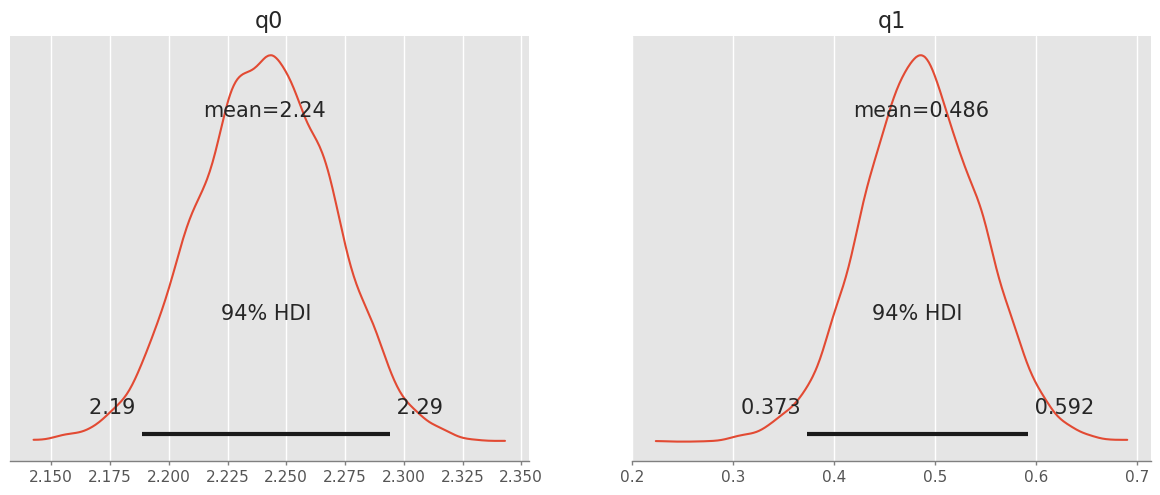

In [35]:
az.plot_posterior(trace, round_to=3)
plt.show()

## 3(d) Bayesian Regression via Bambi

Whew! `q3(c)` took *a lot* of code just to build a simple Poisson regression. In practice, building models from scratch like this is usually unnecessary unless we're looking for a custom solution. Instead, we can rely on packages like `Bambi` that *wrap* the functionality of `PyMC` with a simpler interface purely designed for GLMs.

Using [`Bambi` documentation](https://bambinos.github.io/bambi/) as a guide, fill out the code cell below to fit a Bayesian Poisson Regression model on our data. 

**Note 1**: To pass the autograder, make sure you pass your model the `random_seed = 0` when you fit it!

**Note 2**: Notice that the `Bambi` package doesn't need us to specify a prior: when we don't specify a prior for our model parameters, Bambi automatically supplies a weakly informative one based on your data by default. For this question, we are okay with this behavior: **to pass the test, do not specify a prior on your parameters!**

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Temp_Anomaly]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


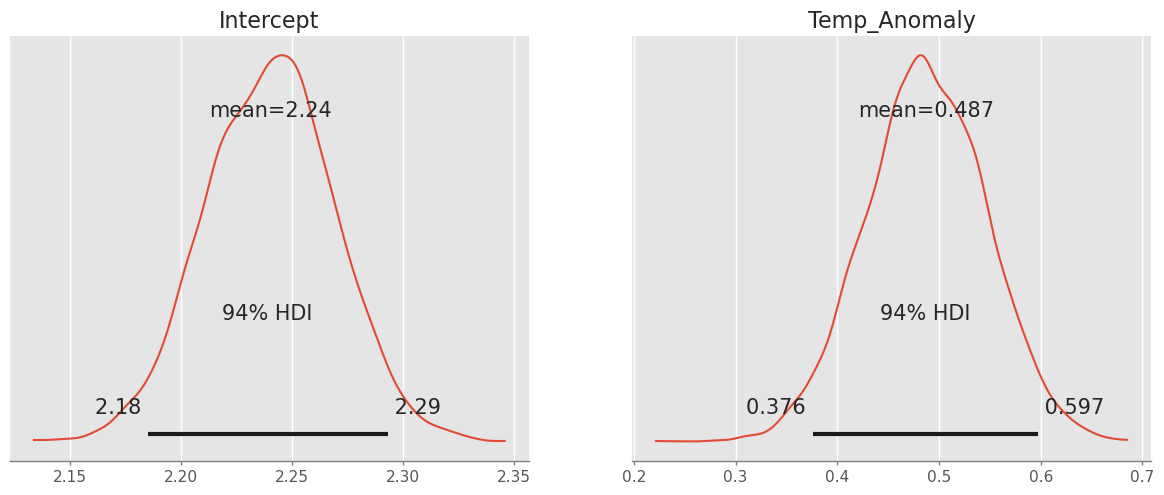

In [36]:
my_model = bmb.Model("Num_Storms ~ Temp_Anomaly", data=df, family="poisson")
my_model_samples = my_model.fit(draws=2000, chains=4, random_seed=0)

az.plot_posterior(my_model_samples, round_to=3)
plt.show()

In [37]:
grader.check("q3d")

q3d results: All test cases passed!

<!-- BEGIN QUESTION -->

### 3(e) Understanding the plots
What the are x-axis and y-axis in each of the plots in 3d)? Your answer should be in terms of the parameters of our model.

Each plot represents the poster distribution of a parameter in our Bayesian Poisson regression model. The x-axis represents the possible values of the parameter. The y-axis represents the posterior probability density of the parameter. More formally, the plot on the left represents the intercept. Thus, the x-axis represents the posterior distribution of the intercept's coefficient (q0) and the y-axis represents the probability density of the intercept values. We can interpret the plot on the left as, the mean value of the posterior distribution is 2.24, with a 94% highest density interval (HDI) between 2.18 and 2.29. The right plot represents the Temp_Anomaly covariate. Where the x-axis represents the posterior distribution of the coefficient for Temp_Anomaly (q1) and the y-axis represents the probability density of q1 values. We can interpret the plot as, the mean value of the posterior distribution is 0.487, with a 94% highest density interval (HDI) between 0.376 and 0.597. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 3(f) Comparison

Compare the results of `freq_model` in 3(b) with the plot in 3(d). Are the estimates of Frequentist and Bayesian Regression close to each other? 

The estimates from the Frequentist and Bayseian regression models are very close to each other. In the frequentist model (3b), the estimated coefficient for the intercept (constant term) is 0.2414 with a standard error of 0.029, while the Bayesian model (3d) gives a mean posterior estimate of 2.24 with a 94% HDI between 2.18 and 2.29. Similarly, the coefficient for Temp_Anomaly in the frequentist model is 0.4866 with a standard error of 0.059, and the Bayesian posterior is 0.487, with a 94% HDI between 0.376 and 0.597.The close agreement between the two methods suggest that the Bayesian approach, using weakly informative priors, produces similar estimates to the maximum likelihood estimation used in the frequentist approach.

<!-- END QUESTION -->

## Well done!
You've reached the end of the lab! Make sure you double check your work and make sure that you've answered all the written portions of the lab.

Before you submit to Gradescope, make sure you pass all the autograded portions of this lab. **Run the cell below to generate a PDF of your lab submission**, and **run the last cell to generate a zip file of your lab submission.** Do **not** create your lab PDF by exporting your notebook to a PDF.

To submit your lab to Gradescope, submit the PDF to Lab 5 Written and the zip file to Lab 5 Code.

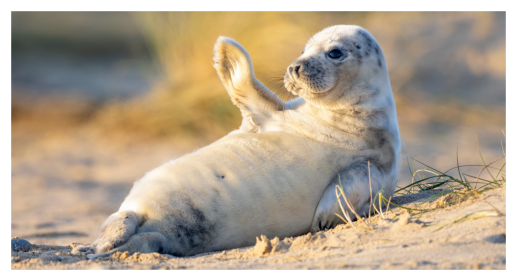

In [38]:
import matplotlib.image as mpimg
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("lab05.ipynb", filtering=True, pagebreaks=True)
if(path.exists('lab05.pdf')):
    img = mpimg.imread('baby_seal.png')
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()
    display(HTML("Download your PDF <a href='lab05.pdf' download>here</a>."))

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [39]:
grader.check_all()

q1a_ii results: All test cases passed!

q1b_i results: All test cases passed!

q2a results: All test cases passed!

q3c_i results: All test cases passed!

q3c_iii results: All test cases passed!

q3d results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [136]:
grader.export(pdf=False, force_save=True)

<IPython.core.display.Javascript object>